# Is Estimated Inversion Strength a useful metric for EUREC4A type simulations?

we calulated metrics. 
some are highly correlated
these correlations are meaningless

- EIS is correlated to LTS
- EIS is centered around 0, Wood&Bretherton: range between 1-10K
- -> EIS is residual of LTS
- missing plot: EIS correlation with cloud cover (needs roll out of analysis on the whole dataset, work in progress)

## What correlations do we see in the metrics we calculated?

We lower tropospheric stability (LTS) and estimated inversion strenght (EIS) for our dataset, because they are suspected to be cloud controlling factors. Further we calculated lifting condensation level (LCL) height (or pressure) as it's needed to calculate EIS and cloud top height. Here we will also be looking at surface temperature and humidity, as they are used in the calculation of the above metrics. If we look at how these metrics are correlated among each other two correlations stand out (by being exceptionally high):
- near surface relative humidity and LCL height.
- LTS and EIS

In [1]:
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import os
import file_handling as fh
import postprocessing as pp
import calculations as cc
import xarray as xr
fh.disable_warnings()

def load_warm(exp_dir = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/'):
    datasets = list()
    
    file_list = fh.disk_data_from_keywords(exp_dir, ['3D', 'DOM01'], return_file_list=1)[10:20]
    data = xr.open_mfdataset(file_list, combine = 'nested', concat_dim="time")
    data = pp.clean_volume_data(data)
    datasets.append(data)
    
    file_list = fh.disk_data_from_keywords(exp_dir, ['radiation', 'DOM01'], return_file_list=1)
    data = xr.open_mfdataset(file_list, combine = 'nested', concat_dim="time")
    data = pp.clean_surface_data(data)
    datasets.append(data)
    
    file_list = fh.disk_data_from_keywords(exp_dir, ['surface', 'DOM01'], return_file_list=1)
    data = xr.open_mfdataset(file_list, combine = 'nested', concat_dim="time")
    data = pp.clean_surface_data(data)
    datasets.append(data)
    
    datasets = pp.time_overlap(datasets)
    data = xr.merge(datasets)
    return data

def load_ctrl():
    datasets = [fh.eureca_data_from_keywords(['3D', 'DOM01']), fh.eureca_data_from_keywords(['surface', 'DOM01']), fh.eureca_data_from_keywords(['radiation', 'DOM01'])]
    datasets = pp.time_overlap(datasets)
    data = xr.merge(datasets)
    # data, warm = pp.time_overlap([data, warm])
    return data

def subsample(data, ncells=1000):
    data = pp.filter_by_threshold(data, {'tqi_dia':1e-4}, below_threshold=True, chunk_size=None)
    data = pp.filter_by_threshold(data, {'tqc_dia':1e-1}, below_threshold=False, chunk_size=None)
    data = pp.random_subsample(data, {'cell':ncells}).squeeze()
    data = calculate_metrics(data, drop_vars=False)
    data = pp.filter_by_threshold(data, {'cth':11}, below_threshold=False, chunk_size=None)
    return data

def calculate_metrics(data, drop_vars=True):
    data_vars = list(data)
    data = pp.replace_height_indices_with_values(data)
    data = cc.add_lifting_condensation_level_pressure(data)
    data = cc.add_lower_tropospheric_stability(data)
    data = cc.add_estimated_lapse_rate_stability(data)
    data = cc.add_cloud_top_height(data)
    data = data.compute()
    data['eis'] = data['lts'] - data['elrs']
    data['eis'].attrs['long_name'] = 'estimated inversion strenght'
    if drop_vars: data = data.drop_vars(data_vars)
    return data


nsamples = 2000
warm = load_warm()
ctrl = load_ctrl()
ctrl, warm = pp.time_overlap([ctrl, warm])
ctrl = subsample(ctrl, nsamples)
warm = subsample(warm, nsamples)

Any code that generates warnings will no longer print them to the console.


In [2]:
def remove_dimension(dataset: xr.Dataset, dim_name: str) -> xr.Dataset:
    """
    Remove all variables along a specified dimension from an xarray.Dataset and also remove the dimension itself.

    Parameters:
    ds (xarray.Dataset): The input xarray.Dataset from which variables and the dimension will be removed.
    dim_name (str): The name of the dimension to be removed along with all variables associated with it.

    Returns:
    xarray.Dataset: A new xarray.Dataset with the specified dimension and its associated variables removed.
    """
    vars_to_remove = [var for var in dataset.data_vars if dim_name in dataset[var].dims]
    dataset = dataset.drop_vars(vars_to_remove)
    dataset = dataset.drop_dims(dim_name)
    return dataset

In [17]:
import matplotlib.pyplot as plt
import plot_utils as pu

variables = ['lts', 'eis', 'rh_2m', 'lcl_pres', 'cth', 't_2m']

fig, axs = plt.subplots(1,2, figsize=(10,5))
ax =axs[0]
for ax, dataset, label in zip(axs, [ctrl, warm], ['control', 'warming']):
    d = remove_dimension(dataset, 'height')
    ax = pu.ax_correlation_matrix(ax, d[variables])
    ax.set_title(label)
ax = pu.remove_ticks(ax, ['left', 'right'])
fig.tight_layout()
fig.show()

## LCL pressure and surface relative humidity

The LCL height is the height were a surface air parcel starts condensating when lifted vertically. You can imagine it as the intersection of the dry lapse rate and the dew point lapse rate. Naturally, the higher the relative humidity of a parcel is the earlier it will start to condensate. The relationship of the two can also be seen in analytic formulations of LCL (e.g. Romps, 2017):

$$ T_{LCL} =  c[W_{-1} (RH_l^{1/a} cd^c ) ] ^{-1} T $$

$$ p_{LCL} = p ( \frac{T_{LCL}}{T}) ^{c_{pm} / R_m} $$

Thus this correlation is expected.

In [16]:
variables = ['rh_2m', 'lcl_pres']
fig, ax = plt.subplots()
for data, kwargs in zip([ctrl, warm], [{'color':'black'}, {'color':'red'}]):
    ax = pu.ax_variable_correlation(ax, data, variables, kwargs=kwargs)
fig.show()

## Lower tropospheric stability (LTS) and estimated inversion strength (EIS)

Much like in the above example, LTS and EIS are expected to be correlated, because LTS is the basis for calculating EIS. EIS was intended to be a refinement of LTS, separating the lapse rate contribution to stability from the inversions contribution (Wood & Bretherton, 2016).

$$ \text{EIS} = \text{LTS} - \Gamma_m^{850} (z_{700} - \text{LCL}) $$

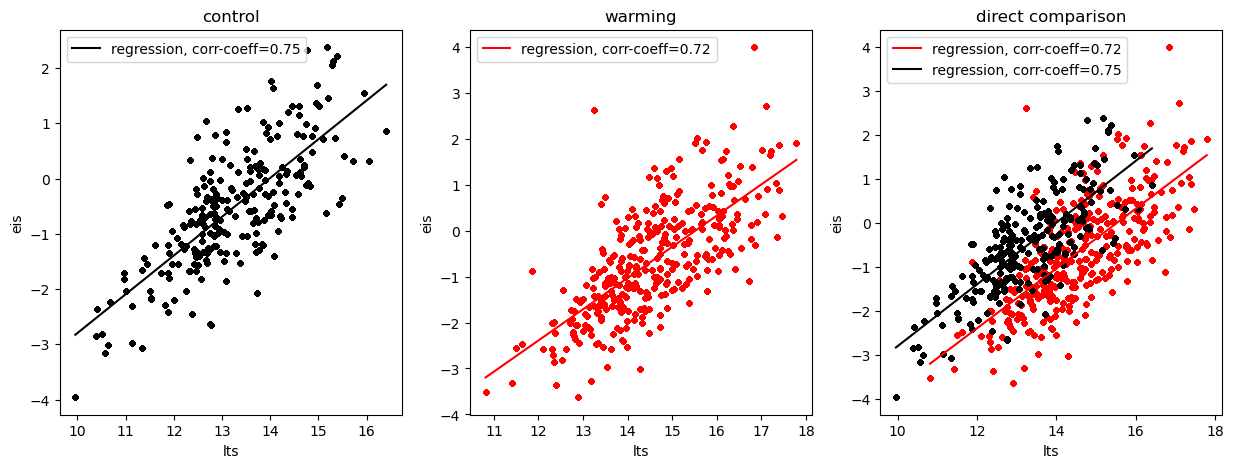

In [21]:
variables = ['lts', 'eis']
fig, axs = plt.subplots(1,3, figsize=(15,5))
for ax, data, title, kwargs in zip(axs, [ctrl, warm, warm], ['control', 'warming', 'direct comparison'], [{'color':'black'}, {'color':'red'}, {'color':'red'}]):
    ax = pu.ax_variable_correlation(ax, data, variables, kwargs=kwargs)
    ax.set_title(title)
ax = pu.ax_variable_correlation(ax, ctrl, variables, kwargs={'color':'black'})
fig.show()

Wood and Bretherton focus their analysis on stratocumulus regimes. Yet they state that EIS is a good indicator for cloudiness in other regimes, too, including mid latitudes. They speak of inversions having a strenght of $ 1 - 10\,K$ ($\Delta \theta$). In our data EIS is centered around zero, rarely exceeding 1 and mostly below zero.

Even though there seems to be a correlation, I would claim that EIS here serves as a residual term for any behaviour of LTS that is not strictly the idealised lapse at $850\,\text{hPa}$, that is assumed for EIS calculation.

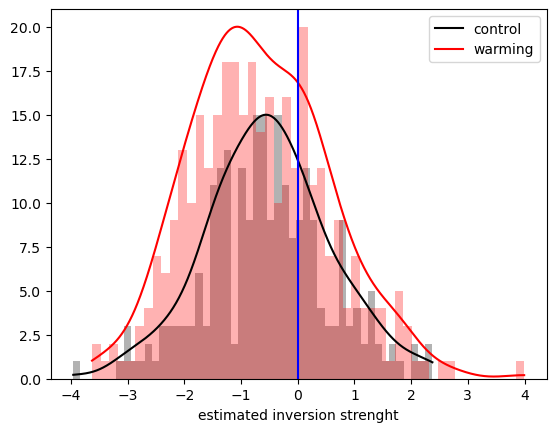

In [25]:
var = 'eis'

fig, ax = plt.subplots()
kwargs = [ {'label': 'control', 'color': 'black'},
           {'label': 'warming', 'color': 'red'} ]
for dataset, kws in zip([ctrl, warm], kwargs):
    ax = pu.ax_histogram(ax, dataset, var, **kws)
ax.axvline(0, c='b')
fig.show()

## References 
- Romps, D. M. (2017). Exact expression for the lifting condensation level. *Journal of the Atmospheric Sciences*, 74(12), 3891-3900.
- Wood, R., & Bretherton, C. S. (2006). On the relationship between stratiform low cloud cover and lower-tropospheric stability. *Journal of climate*, 19(24), 6425-6432.